In [1]:
options(warn = -1, tidyverse.quiet = T)

library(tidyverse, warn.conflicts = F, quietly = T)
library(arrow, warn.conflicts = F)
library(cowplot, warn.conflicts = F)
library(yardstick, warn.conflicts = F)
library(kableExtra, warn.conflicts = F)

In [2]:
feature_phenotypes <- c(
    "Cerebral infarction" = "b_I63",
    "Acute myocardial infarction" = "b_I21",
    "Essential hypertension" = "b_I10",
    "Obesity" = "b_E66",
    "Acute ischemic heart disease" = "b_I24",
    "Ischemic heart disease" = "b_I25",
    "Pulmonary heart diseases" = "b_I27",
    "Other heart disease" = "b_I51",
    "Other cerebrovascular" = "b_I67",
    "Type 1 diabetes mellitus" = "b_E10",
    "Type 2 diabetes mellitus" = "b_E11",
    "HbA1c" = "q_30750_0",
    "HDL cholesterol" = "q_30760_0",
    "Glucose" = "q_30740_0",
    "Cholesterol" = "q_30690_0",
    "Triglycerides" = "q_30870_0",
    "Lipoprotein A" = "q_30790_0",
    "Apolipoprotein B" = "q_30640_0",
    "Creatinine" = "q_30700_0"
)
reversed_feature_phenotypes = names(feature_phenotypes) %>% set_names(feature_phenotypes)

megastroke_phenotypes <- c(
    AS = "Any",
    AIS = "Ischemic",
    LAS = "Large artery",
    CES = "Cardioembolic",
    SVS = "Small vessel"
)
reversed_megastroke_phenotypes = names(megastroke_phenotypes) %>% set_names(megastroke_phenotypes)

In [3]:
gcov_df <- read_tsv("data/gcov/MEGASTROKE.naive.tsv", show_col_types = F) %>%
    mutate(
        megastroke_phenotype = megastroke_phenotype %>%
            str_remove("^[0-5]\\.") %>%
            recode(!!!megastroke_phenotypes)
    )

coef_df <- read_parquet("plot_data/maxgcp_coef.parquet")

In [4]:
gcov_plot_df <- gcov_df %>%
    filter(Component == "Cor_All") %>%
    select(-Component) %>%
    filter(str_starts(phenotype_id, "b_|q_")) %>%
    mutate(phenotype_id = recode(phenotype_id, !!!reversed_feature_phenotypes)) %>%
    arrange(desc(Value)) %>%
    select(`Stroke type` = megastroke_phenotype, `Phenotype` = phenotype_id, 
           `Genetic correlation` = Value, `Standard error` = SD) %>%
    inner_join(coef_df, by = c("Phenotype" = "feature", "Stroke type" = "phenotype")) %>%
    rename(`MaxGCP coefficient` = value)

gcov_plot_df %>% head(2)

Stroke type,Phenotype,Genetic correlation,Standard error,MaxGCP coefficient
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Small vessel,Obesity,0.919097,1.390108,1.435306
Any,Cerebral infarction,0.847350,0.160247,2.466898


Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2

Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom



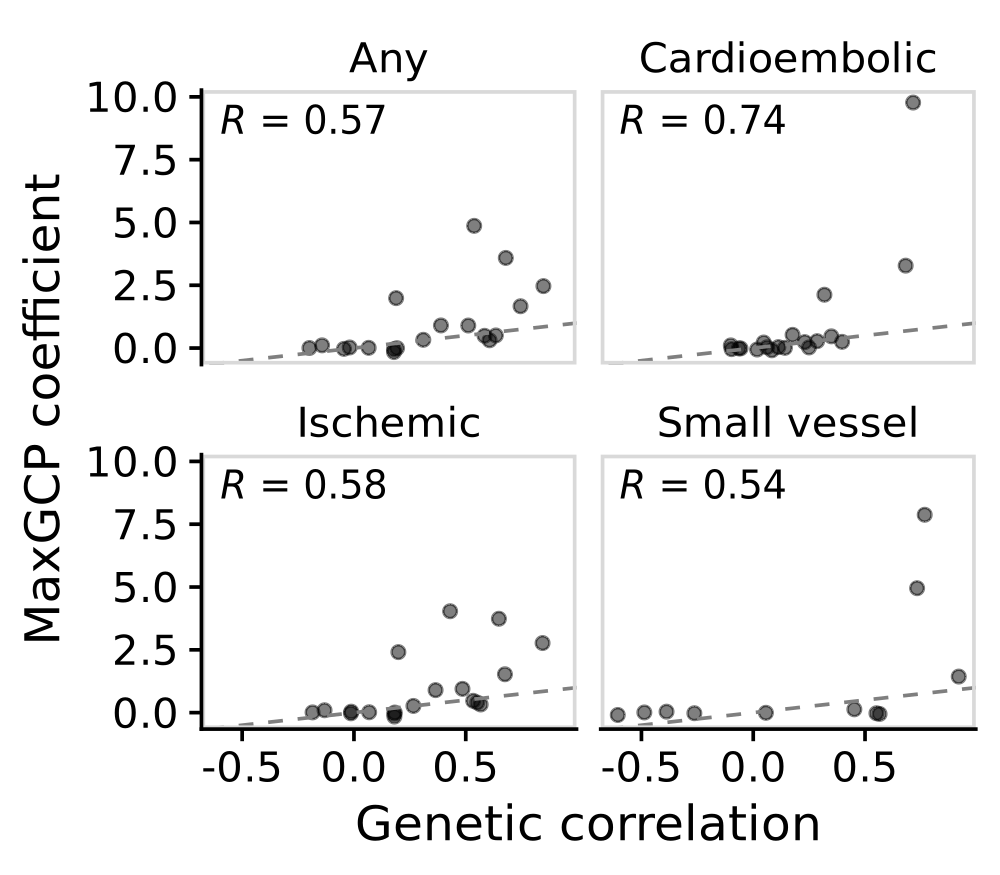

In [5]:
options(repr.plot.width = 4, repr.plot.height = 3.5, repr.plot.res = 250)

rg_vs_coef_plot <- gcov_plot_df %>%
    ggplot(aes(x = `Genetic correlation`, y = `MaxGCP coefficient`)) +
    geom_point(alpha = 0.5) +
    facet_wrap(vars(`Stroke type`)) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    theme_cowplot() +
    theme(
        strip.background = element_blank()
    ) +
    panel_border() +
    ggpmisc::stat_correlation()

save_plot("img/rg_vs_coef.png", rg_vs_coef_plot, base_width = 4, base_height = 3.5,
          dpi = 400, bg = "white")

rg_vs_coef_plot

In [6]:
summary_df <- read_parquet("plot_data/summary.parquet")

target_sensitivity_specificity_df <- read_parquet(
    "plot_data/target_sensitivity_specificity.parquet")

In [7]:
plot_df <- target_sensitivity_specificity_df %>%
    pivot_wider(names_from = metric) %>%
    inner_join(
        summary_df %>%
            select(mega_type, phenotype_id, sensitivity, specificity),
        by = c("mega_type", "phenotype_id"),
        suffix = c("_target", "_fixed")
    ) %>%
    mutate(
        cohort = str_extract(phenotype_id, "N=[0-9]+"),
        phenotype = str_extract(phenotype_id, "^[A-Za-z]+")
    ) %>%
    ungroup %>%
    select(mega_type, cohort, phenotype, sensitivity, specificity,
           `Sensitivity (at 90% specificity)` = `Sensitivity\n(at 90% specificity)`, 
           `Specificity (at 10% sensitivity)` = `Specificity\n(at 10% sensitivity)`)

In [8]:
plot_df %>%
    kbl("latex", digits = 3) %>%
    collapse_rows(columns = 1:2, valign = "middle") %>%
    kable_classic %>%
    kable_paper %>%
    add_header_above(c(" " = 3, "P-value" = 2, "Fixed" = 2))

\begin{table}
\centering\centering
\begin{tabular}[t]{l|l|l|r|r|r|r}
\hline
\multicolumn{3}{c|}{ } & \multicolumn{2}{c|}{P-value} & \multicolumn{2}{c}{Fixed} \\
\cline{4-5} \cline{6-7}
mega\_type & cohort & phenotype & sensitivity & specificity & Sensitivity (at 90\% specificity) & Specificity (at 10\% sensitivity)\\
\hline
 &  & MaxGCP & 0.120 & 0.910 & 0.130 & 0.929\\
\cline{3-7}
 & \multirow{-2}{*}{\raggedright\arraybackslash N=350} & Naive & 0.065 & 0.947 & 0.114 & 0.913\\
\cline{2-7}
 &  & MaxGCP & 0.055 & 0.947 & 0.101 & 0.901\\
\cline{3-7}
\multirow{-4}{*}[0.5\dimexpr\aboverulesep+\belowrulesep+\cmidrulewidth]{\raggedright\arraybackslash Any} & \multirow{-2}{*}{\raggedright\arraybackslash N=15} & Naive & 0.057 & 0.948 & 0.105 & 0.906\\
\cline{1-7}
 &  & MaxGCP & 0.120 & 0.911 & 0.132 & 0.931\\
\cline{3-7}
 & \multirow{-2}{*}{\raggedright\arraybackslash N=350} & Naive & 0.065 & 0.947 & 0.113 & 0.913\\
\cline{2-7}
 &  & MaxGCP & 0.054 & 0.948 & 0.104 & 0.904\\
\cline{3-7}
\multiro